# Computing - Chapter 03 - (Python)

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame,Series

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# load the data from a file
DATA_PATH = "../data"
segDataRaw = pd.read_csv(DATA_PATH + "/segmentationOriginal.csv")
segDataRaw.head()

,Cell,Case,Class,AngleCh1,AngleStatusCh1,AreaCh1,AreaStatusCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,...,VarIntenCh1,VarIntenCh3,VarIntenCh4,VarIntenStatusCh1,VarIntenStatusCh3,VarIntenStatusCh4,WidthCh1,WidthStatusCh1,XCentroid,YCentroid
0,207827637,Test,PS,143.247705,1,185,0,15.711864,3.954802,9.548023,...,12.474676,7.609035,2.714100,0,2,2,10.642974,2,42,14
1,207932307,Train,PS,133.752037,0,819,1,31.923274,205.878517,69.916880,...,18.809225,56.715352,118.388139,0,0,0,32.161261,1,215,347
2,207932463,Train,WS,106.646387,0,431,0,28.038835,115.315534,63.941748,...,17.295643,37.671053,49.470524,0,0,0,21.185525,0,371,252
3,207932470,Train,PS,69.150325,0,298,0,19.456140,101.294737,28.217544,...,13.818968,30.005643,24.749537,0,0,2,13.392830,0,487,295
4,207932455,Test,PS,2.887837,2,285,0,24.275735,111.415441,20.474265,...,15.407972,20.504288,45.450457,0,0,0,13.198561,0,283,159


In [4]:
# isolate just the training examples
segData = segDataRaw[segDataRaw.Case == "Train"]

In [5]:
# pull out some of the columns
cellId = segData.Cell
cellClass = segData['Class']
case = segData.Case

In [6]:
# now remove the columns
segData = segData.drop(['Cell', 'Class', 'Case'], axis=1)

In [7]:
# remove all "Status" columns
segData = segData.drop([c for c in segData.columns if "Status" in c], axis=1)

## Transformations

### Skewness

In [8]:
# for one predictor
from scipy.stats import skew
skew(segData.AngleCh1)

-0.024298630435426738

In [9]:
# apply across all columns
skewValues = segData.apply(skew, axis=0)
[print(x) for x in list(zip(segData.columns, skewValues))[0:5]];

('AngleCh1', -0.024298630435426738)
('AreaCh1', 3.5303544460710095)
('AvgIntenCh1', 2.9635898861967189)
('AvgIntenCh2', 0.84942278590563092)
('AvgIntenCh3', 2.2056202512609824)


### Box Cox Transformation

In [10]:
# find the appropriate box cox transform and apply to values
from scipy.stats import boxcox

(boxCoxTrans, lmbda) = boxcox(segData.AreaCh1)
print(segData.AreaCh1.describe())
print('Largest/Smallest: %.1f' % (segData.AreaCh1.max()/segData.AreaCh1.min()))
print('Sample Skewness: %.2f' % (segData.AreaCh1.skew(),))

print('Estimated Lambda: %f' % (lmbda,))
print('example transformed values: %s ...' % boxCoxTrans[0:5])

count    1009.000000
mean      325.125867
std       216.555276
min       150.000000
25%       194.000000
50%       256.000000
75%       376.000000
max      2186.000000
Name: AreaCh1, dtype: float64
Largest/Smallest: 14.6
Sample Skewness: 3.54
Estimated Lambda: -0.855869
example transformed values: [ 1.16465199  1.16190479  1.15949121  1.15825373  1.15832111] ...


In [11]:
# for comparison, perform the manual transformation using the lambda value generated above
segData.AreaCh1.head()

1     819
2     431
3     298
11    256
14    258
Name: AreaCh1, dtype: int64

In [12]:
import math

print("Automatically generated transformation: %f" % boxCoxTrans[0])
manuallyGenerated = (math.pow(segData.AreaCh1[1], lmbda) - 1) / lmbda
print("Manually generated transformation: %f" % manuallyGenerated)

Automatically generated transformation: 1.164652
Manually generated transformation: 1.164652


### Scaling

In [13]:
import sklearn.preprocessing

scaler = sklearn.preprocessing.StandardScaler().fit(segData)

print(scaler.mean_[0:5])
print(scaler.scale_[0:5])

scaledData = scaler.transform(segData)

# TODO: zip columns, scaler mean/std, pd mean/std

[  91.12640825  325.1258672   127.91502974  185.19067407   96.12916894]
[  48.88765639  216.44793745  163.93228319  153.91029071   93.48906669]


### PCA

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
pcaObject = pca.fit(scaledData)
percentVariance = [pctVariance * 100 for pctVariance in pcaObject.explained_variance_ratio_]
percentVariance[0:3]

[20.91235927892339, 17.013300362584811, 11.886891590935015]

In [15]:
pcaTransform = DataFrame(pca.transform(scaledData)).iloc[0:5, 0:5]
pcaTransform.columns = ["PC1", "PC2", "PC3", "PC4", "PC5"]
pcaTransform

,PC1,PC2,PC3,PC4,PC5
0,5.101103,4.553637,-0.033468,-2.641648,1.278955
1,-0.254752,1.198627,-1.021102,-3.732929,0.999959
2,1.293535,-1.864859,-1.251725,-2.416054,-1.492223
3,-1.465388,-1.566609,0.469854,-3.390396,-0.330396
4,-0.876712,-1.279640,-1.338606,-3.518538,0.393805


In [16]:
pcaComponents = DataFrame(pcaObject.components_.T).iloc[0:6, 0:5]
pcaComponents.columns = ["PC1", "PC2", "PC3", "PC4", "PC5"]
pcaComponents.set_index(segData.columns[0:6])

,PC1,PC2,PC3,PC4,PC5
AngleCh1,0.001214,-0.012845,0.006816,-0.027557,0.025237
AreaCh1,0.229172,0.160617,0.089812,-0.055231,0.052735
AvgIntenCh1,-0.102709,0.179713,0.067697,0.186756,0.024012
AvgIntenCh2,-0.154829,0.163760,0.073534,0.041458,0.078392
AvgIntenCh3,-0.058042,0.111977,-0.185473,0.282913,-0.078224
AvgIntenCh4,-0.117343,0.210391,-0.105061,0.011164,0.049905


### Spatial Sign

See ... (**TODO**)

### Impute via KNN

**TODO**

## Filtering

### Near-zero Variance Features

In [48]:
# identify any predictors that are low variance (e.g. unique value across all entries, etc.) as potentials for removal
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold()
selection = selector.fit(segData)

# for our segmentation data, none of the predictors fit the conditions
selection.get_support()

# if there were any near-zero variance predictors, we could remove them using the
# results as a column 'mask'
# segData = segData.iloc[:, selection.get_support()]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

### Between-predictor correlations

In [35]:
correlations = segData.corr()
correlations.shape

(58, 58)

In [36]:
correlations.iloc[:4, :4]

,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2
AngleCh1,1.000000,-0.002627,-0.043008,-0.019447
AreaCh1,-0.002627,1.000000,-0.025297,-0.153303
AvgIntenCh1,-0.043008,-0.025297,1.000000,0.525217
AvgIntenCh2,-0.019447,-0.153303,0.525217,1.000000


### Correlation Matrix

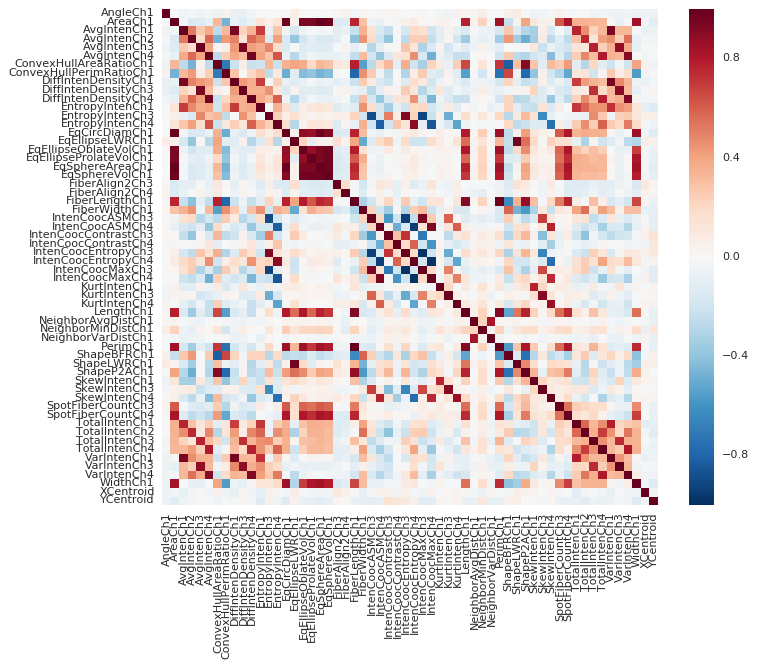

In [46]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, 
            xticklabels=correlations.columns.values,
            yticklabels=correlations.columns.values);

### FindCorrelations

In [60]:
temp = correlations.reset_index(level=0)
corrs = pd.melt(temp, id_vars=['index'])

(corrs[~(corrs['index'] == corrs['variable'])]).sort_values(by='value')

,index,variable,value
1654,IntenCoocMaxCh3,IntenCoocEntropyCh3,-0.990544
1768,IntenCoocEntropyCh3,IntenCoocMaxCh3,-0.990544
1713,IntenCoocMaxCh4,IntenCoocEntropyCh4,-0.984572
1827,IntenCoocEntropyCh4,IntenCoocMaxCh4,-0.984572
1648,IntenCoocASMCh3,IntenCoocEntropyCh3,-0.945202
1420,IntenCoocEntropyCh3,IntenCoocASMCh3,-0.945202
1707,IntenCoocASMCh4,IntenCoocEntropyCh4,-0.944684
1479,IntenCoocEntropyCh4,IntenCoocASMCh4,-0.944684
726,IntenCoocMaxCh3,EntropyIntenCh3,-0.922840
1752,EntropyIntenCh3,IntenCoocMaxCh3,-0.922840
